# Getting Started

Welcome to `AIRBALL`!

This notebook goes through the essentials of getting started simulating your own flybys in `REBOUND`.

There are 5 brief sections:

1. Stars
2. StellarEnvironments
3. Initial Mass Functions (IMFs)
4. Units
5. Analytic Estimates

In [1]:
import rebound
import numpy as np
import airball
import airball.units as u
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

matplotlib.rcParams["text.usetex"] = True
%config InlineBackend.figure_format = 'retina'

twopi = 2.0 * np.pi

## 1. Stars

For more detailed examples covering the basics of stellar flyby properties, see the [Basics](../basics/)

The `Star` and `Stars` are the fundamental objects for using `AIRBALL`. You can initialize a single star using `airball.Star`, specifying each parameter specifically, or allowing `AIRBALL` to distribute the incident angles isotropically by default.

In [2]:
star1 = airball.Star(
    m=1 * u.solMass,
    b=250 * u.au,
    v=2.5 * u.km / u.s,
    inc=-34 * u.deg,
    omega=0,
    Omega=twopi / 6,
)
star2 = airball.Star(m=1 * u.solMass, b=250 * u.au, v=2.5 * u.km / u.s)
star1, star2

(<airball.stars.Star object at 0x10c02dd30, m= 1 solMass, b= 250 AU, v= 2.5 km / s, inc= -0.5934 rad, omega= 0 rad, Omega= 1.047 rad>,
 <airball.stars.Star object at 0x117aea350, m= 1 solMass, b= 250 AU, v= 2.5 km / s, inc= 2.149 rad, omega= 4.089 rad, Omega= 2.617 rad>)

Or you can similarly initialize multiple stars at once using `airball.Stars` and then access the stars like a list or `numpy` array. You can save them and load them later too.

In [3]:
stars = airball.Stars(
    m=[0.5, 1, 2] * u.solMass, b=[250, 250, 250] * u.au, v=[1, 2, 3] * u.km / u.s
)
filename = Path.cwd() / "examples_data" / "getting-started" / "triple.stars"
stars.save(filename)
stars

<airball.stars.Stars object at 0x10c02e120, N=3, m= 0.500-2.000 solMass, b= 250-250 AU, v= 1-3 km / s>

In [4]:
triple = airball.Stars(filename)
triple[0], stars[1:]

(<airball.stars.Star object at 0x1181a74d0, m= 0.5 solMass, b= 250 AU, v= 1 km / s, inc= 2.579 rad, omega= 2.71 rad, Omega= -0.6121 rad>,
 <airball.stars.Stars object at 0x10bfc6780, N=2, m= 1.000-2.000 solMass, b= 250-250 AU, v= 2-3 km / s>)

Once a star has been specified, running a flyby simulation using `REBOUND` is as simple as initialization.

In [5]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=5e-5, a=30)

airball.flyby(sim, star1)

<rebound.simulation.Simulation object at 0x1182946d0, N=2, t=2347130.8167529763>

## 2. Stellar Environments

If you would like `AIRBALL` to randomly generate stars for you from a simluated environment, then you can use `airball.StellarEnvironment`. There are also 

In [ ]:
my_env = airball.StellarEnvironment(
    stellar_density=10,
    velocity_dispersion=20,
    lower_mass_limit=0.08,
    upper_mass_limit=8,
    name="My Environment",
)
my_env.stats()
filename = Path.cwd() / "examples_data" / "getting-started" / "my_env.se"
my_env.save(filename)
my_stars = my_env.random_stars(size=100)
print(my_stars)

My Environment
------------------------------------------
Stellar Density:               10 stars / pc3 
Velocity Scale:                20 km / s 
Mass Range:              0.08 - 8 solMass
Median Mass:               0.2298 solMass 
Mean Mass:                 0.4736 solMass 
Max Impact Param:       1.132e+04 AU 
Encounter Rate:             4.585 stars / Myr 
------------------------------------------
<airball.stars.Stars object at 0x1182dc3b0, N=100, m= 0.081-3.530 solMass, b= 823-11,276 AU, v= 3-89 km / s, Environment=My Environment>


If you don't know what kind of environment you would like, consider looking at the [Environments](../../api/environments/) API or the [Stellar Environments](../stellar-environments/) example.

You can also initialize stars from an environment in a single line of code.

In [7]:
easy_stars = airball.Stars(airball.OpenCluster(), size=200)
easy_stars

<airball.stars.Stars object at 0x1181d7240, N=200, m= 0.081-10.035 solMass, b= 63-998 AU, v= 0-5 km / s, Environment=Open Cluster>

## 3. Initial Mass Functions (IMFs)

Initial Mass Functions (IMFs) define the mass distribution that flyby mass samples are pulled from when randomly generating stars from a stellar environment. The default stellar mass function uses a piecewise combination of Salpeter (1955) for $m \geq 1\,M_\odot$ and Chabrier (2003) for single stars for $m < 1\,M_\odot$. You can provide your own IMF when initializing an instance of the class by passing a function to the `mass_function` parameter. You can define an IMF as a standard python function, as a lambda function, or using any of the provided IMFs, see [available IMFs](../../api/imf/#available-imfs). For a more comprehensive example consider reviewing the [IMF notebook](../imf/).

In [8]:
my_dist = airball.imf.broken_power_law(1, -2.3, 1, 0.08 * u.solMass)
imf = airball.IMF(
    min_mass=10 * u.jupiterMass, max_mass=10 * u.solMass, mass_function=my_dist
)

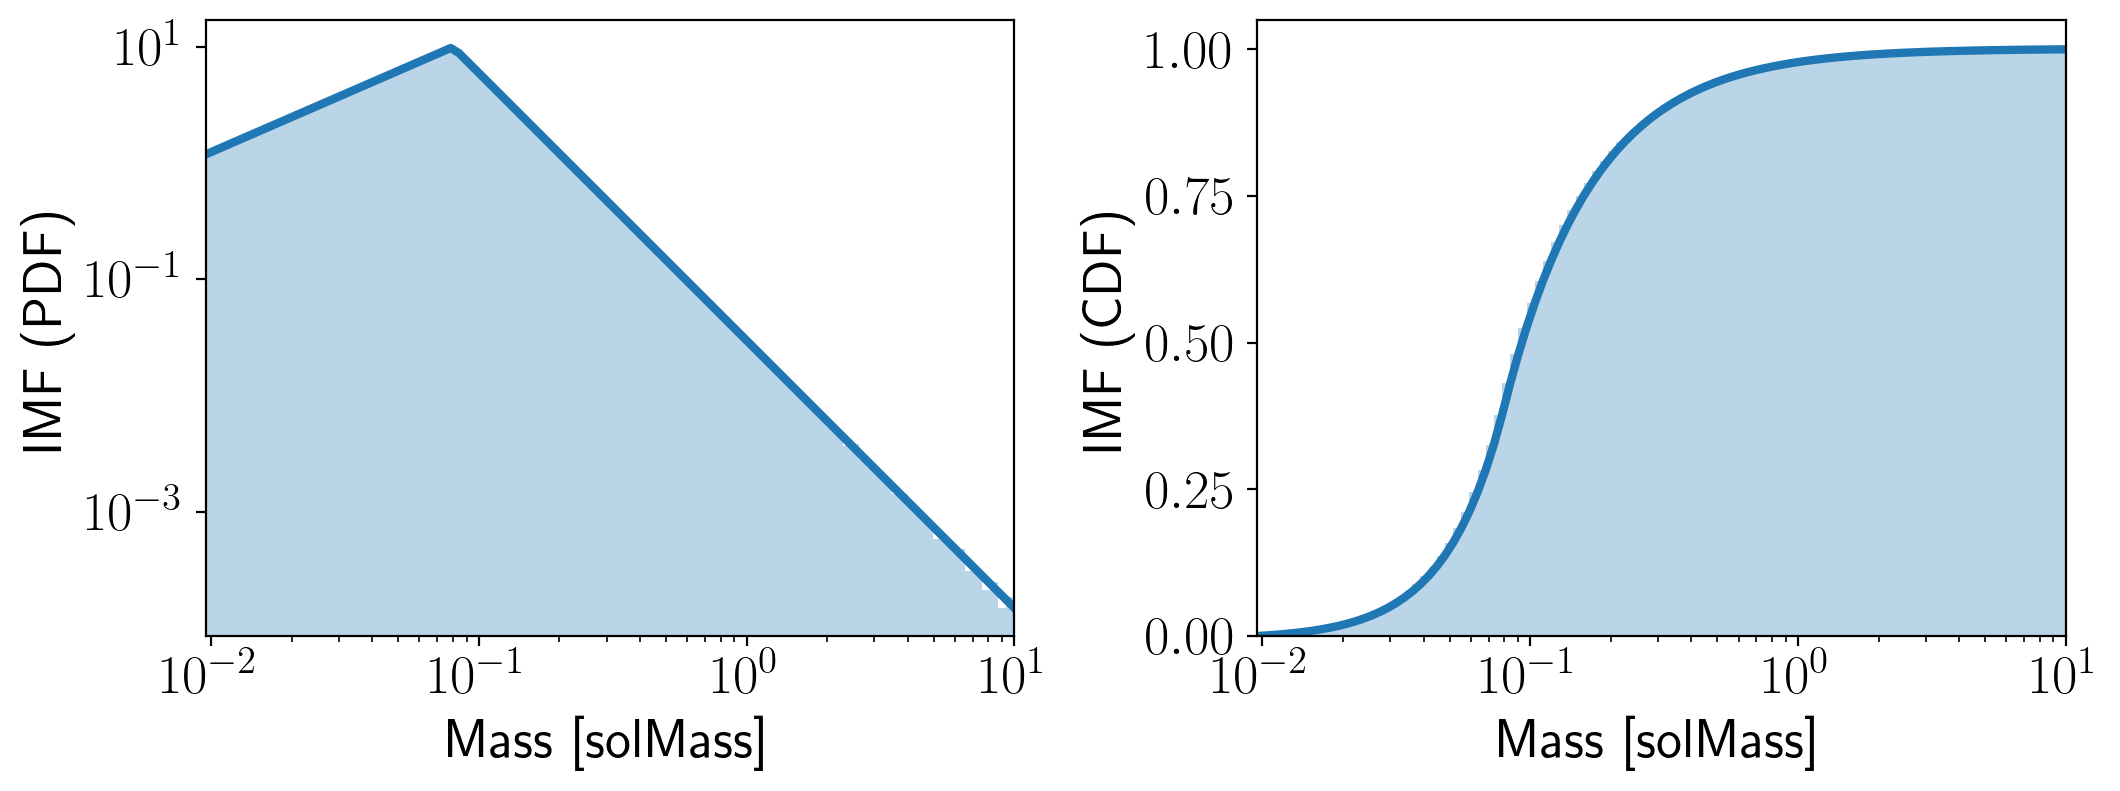

In [9]:
masses = imf.masses(100)
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax[0].loglog(masses, imf.pdf(masses), c="C0", lw=3)
ax[0].hist(
    imf.random_mass(size=1e6).value, bins=masses, color="C0", density=True, alpha=0.3
)
ax[0].set_xlabel(f"Mass [{imf.unit}]")
ax[0].set_ylabel(r"IMF (PDF)")
ax[1].plot(masses, imf.cdf(masses), c="C0", lw=3)
ax[1].hist(
    imf.random_mass(size=1e6).value,
    bins=masses,
    color="C0",
    density=True,
    alpha=0.3,
    cumulative=True,
)
ax[1].set_xlabel(f"Mass [{imf.unit}]")
ax[1].set_ylabel(r"IMF (CDF)")
ax[1].set_xscale("log")
ax[1].set_xlim(imf.mass_range.value)
plt.subplots_adjust(wspace=0.3)
plt.show()

A custom IMF can also be used with a Stellar Environment.

In [10]:
new_env = airball.OpenCluster(
    lower_mass_limit=10 * u.jupiterMass,
    upper_mass_limit=10 * u.solMass,
    mass_function=my_dist,
)
new_env.stats()

Open Cluster
------------------------------------------
Stellar Density:              100 stars / pc3 
Velocity Scale:                 1 km / s 
Mass Range:            0.009546 - 10 solMass
Median Mass:              0.09321 solMass 
Mean Mass:                  0.183 solMass 
Max Impact Param:            1000 AU 
Encounter Rate:           0.01789 stars / Myr 
------------------------------------------


## 4. Units

`airball.units` extends `astropy.units` with a `yr2pi` quantity such that `yr2pi`$= \mathrm{yr}/(2\pi)$. This is the default time unit of `REBOUND` when the central mass object is one solar mass [$M_\odot$], the unit distance is one astronomical unit [AU], and the value of Newton's gravitational constant is `1`. `AIRBALL` manages units using a `UnitSet` class. For more details consider reviewing the [airball.units API](../../api/units/) and the [astropy.units](https://docs.astropy.org/en/stable/units/) documentation.

## 5. Analytic Estimates

For more details, check out the notebook comparing [adiabatic estimates](../adiabatic-tests/).

In [11]:
# Set up a Sun-Neptune system and generate 1000 random flyby stars from an Open Cluster Environment
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=5e-5, a=30)

oc = airball.OpenCluster(seed=1234)
stars = oc.random_stars(size=1000)
stars.sortby("q", sim)

`airball` has implemented a number of analytic expressions from various papers that can be used as a comparative check. For more details, consider the [analytic API documentation](../../api/analytic/). Here we consider adiabatic estimates for changes in to the energy, eccentricity and inclination of Neptune.

In [12]:
est_dE = np.abs(airball.analytic.relative_energy_change(sim, stars))
est_de = np.abs(airball.analytic.eccentricity_change_adiabatic_estimate(sim, stars))
est_di = np.abs(airball.analytic.inclination_change_adiabatic_estimate(sim, stars))

results = airball.hybrid_flybys(sim, stars)

dE, de, di = np.zeros(stars.N), np.zeros(stars.N), np.zeros(stars.N)
nsteps = np.zeros(stars.N)
for i in range(stars.N):
    de[i] = np.abs(results[i].particles[1].e - sim.particles[1].e)
    di[i] = np.abs(np.sin(results[i].particles[1].inc - sim.particles[1].inc))
    dE[i] = np.abs((results[i].energy() - sim.energy()) / sim.energy())
    nsteps[i] = results[i].steps_done

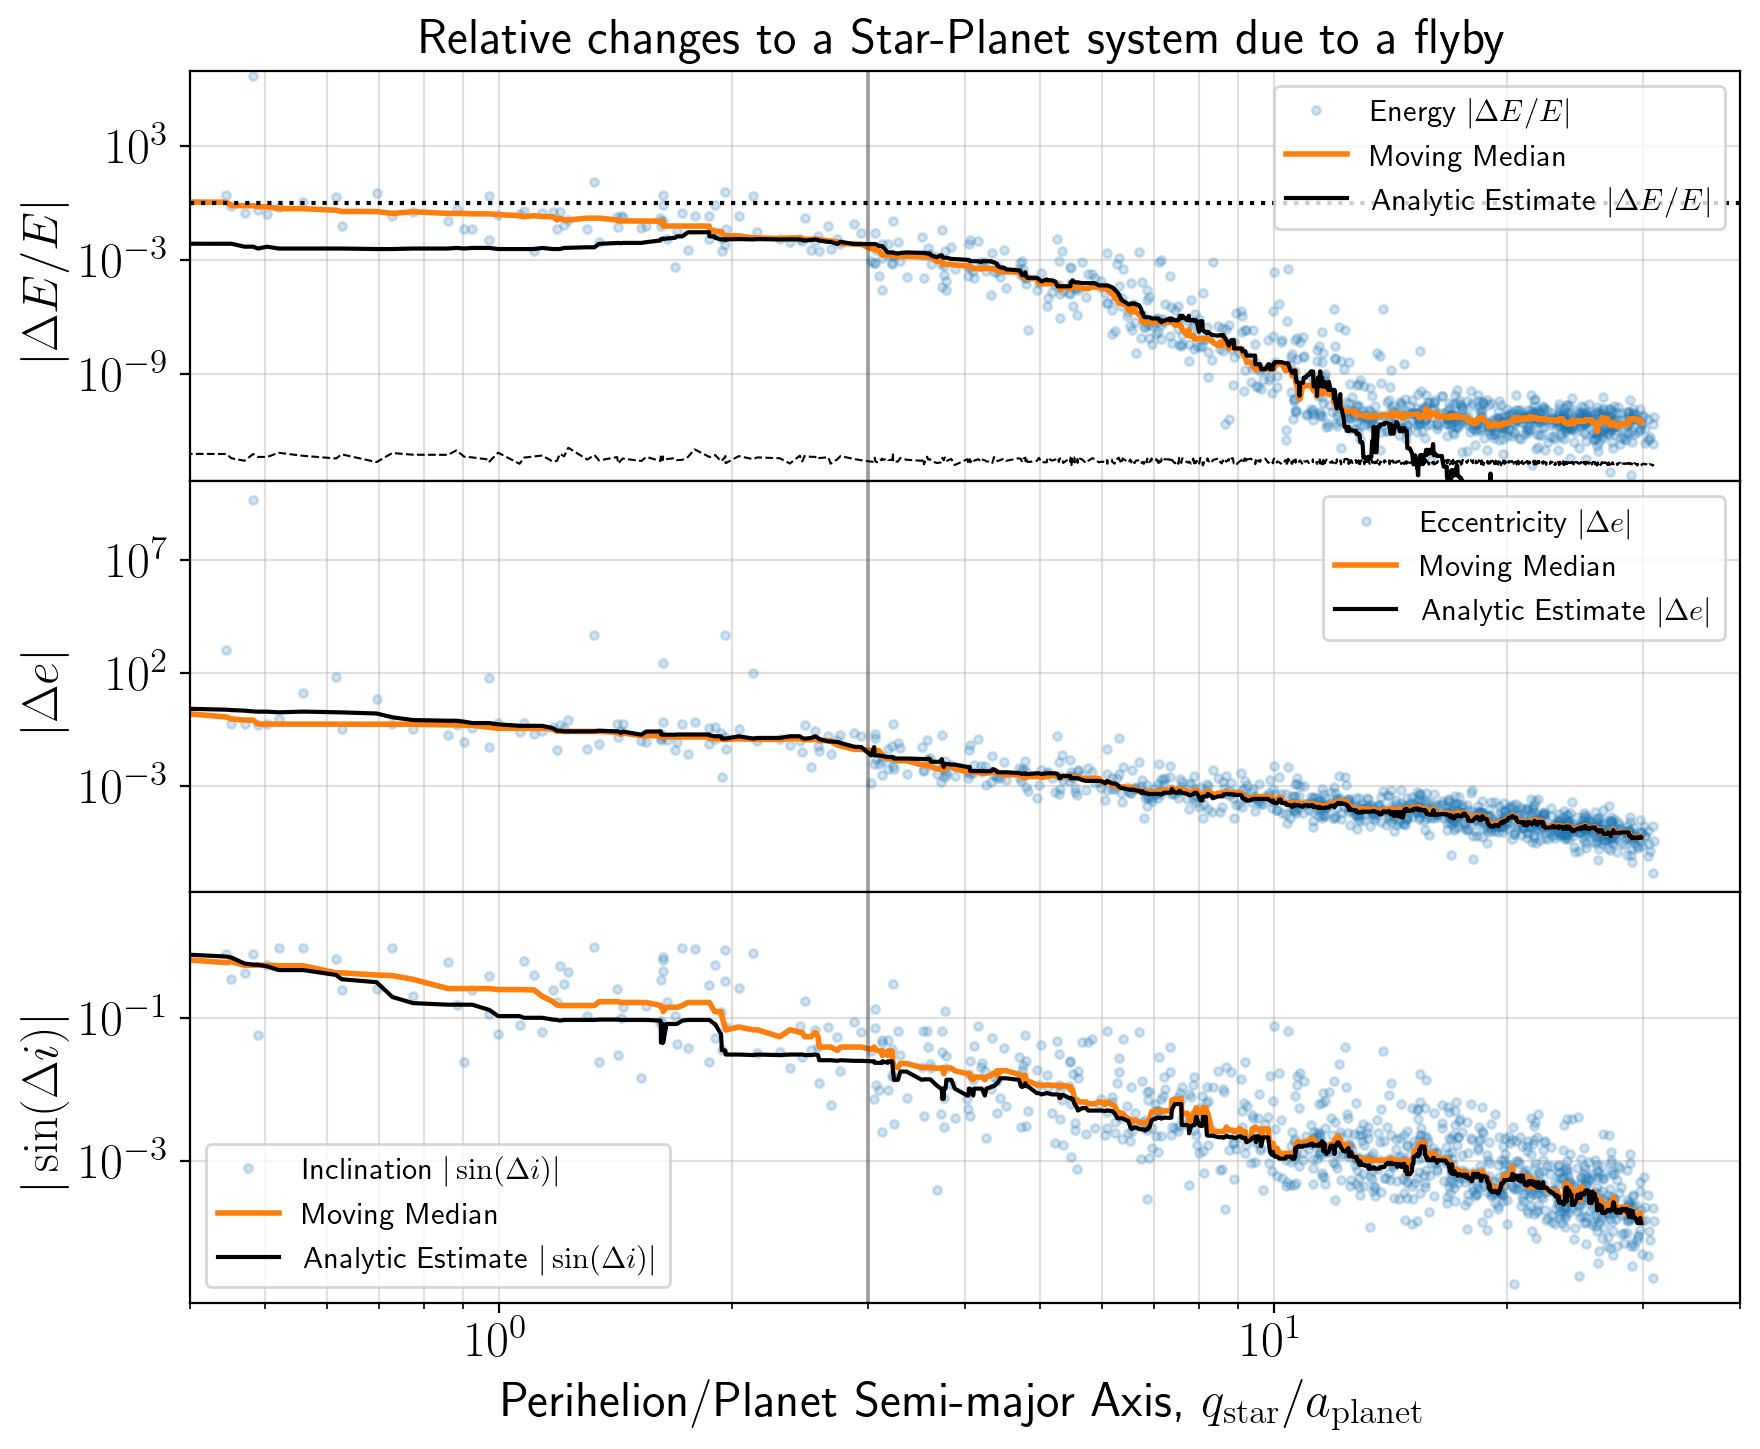

In [13]:
from airball.tools import moving_median as ma

qda = stars.q(sim) / (sim.particles[1].a * u.au)

n = 25
plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
ax[0].set_title(
    "Relative changes to a Star-Planet system due to a flyby", font={"size": 18}
)

ax[0].loglog(qda, dE, "C0.", label=r"Energy $|\Delta E/E|$", alpha=0.2)
ax[0].loglog(ma(qda, n), ma(dE, n, "nan"), "C1-", lw=2, label="Moving Median")
ax[0].loglog(
    ma(qda, n), ma(est_dE, n, "nan"), "k-", label=r"Analytic Estimate $|\Delta E/E|$"
)
ax[0].loglog(qda, 2.0 ** (-53.0) * np.sqrt(nsteps), "k--", lw=0.75)
ax[0].axhline(y=1, ls=":", c="k")
ax[0].set_ylabel(r"$|\Delta E/E|$")
ax[0].set_xlim([0.4, 40])
ax[0].set_ylim([np.min(dE) / 2, np.max(dE) * 2])

ax[1].loglog(qda, de, "C0.", label=r"Eccentricity $|\Delta e|$", alpha=0.2)
ax[1].loglog(ma(qda, n), ma(de, n, "nan"), "C1-", lw=2, label="Moving Median")
ax[1].loglog(
    ma(qda, n), ma(est_de, n, "nan"), "k-", label=r"Analytic Estimate $|\Delta e|$"
)
ax[1].set_ylabel(r"$|\Delta e|$")

ax[2].loglog(qda, di, "C0.", label=r"Inclination $|\sin(\Delta i)|$", alpha=0.2)
ax[2].loglog(ma(qda, n), ma(di, n, "nan"), "C1-", lw=2, label="Moving Median")
ax[2].loglog(
    ma(qda, n),
    ma(est_di, n, "nan"),
    "k-",
    label=r"Analytic Estimate $|\sin(\Delta i)|$",
)
ax[2].set_ylabel(r"$|\sin(\Delta i)|$")
ax[2].set_xlabel(
    r"Perihelion/Planet Semi-major Axis, $q_\mathrm{star}/a_\mathrm{planet}$"
)

for i in range(3):
    ax[i].axvline(3, c="k", alpha=0.3)
    ax[i].legend(prop={"size": 11})
    ax[i].xaxis.grid(True, which="both", alpha=0.4)
    ax[i].yaxis.grid(True, which="both", alpha=0.4)

plt.subplots_adjust(hspace=0.0)
plt.show()

The dynamics of flyby interactions are very rich and the parameter space is very deep. Consider exploring the other [example notebooks](../) mentioned here or review the [API documentation](../../api/). If you have other questions, feel free to [open an issue](https://github.com/zyrxvo/airball/issues) on GitHub or reach out via email.